<a href="https://colab.research.google.com/github/zubair9703/Semantic-Segmentation-on-Sentinel/blob/main/Classification_ACC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install segmentation_models
!pip install pyrsgis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import segmentation_models as sm 
import tensorflow as tf
from tensorflow.keras.utils import normalize
import os
import glob
import cv2
from skimage.io import imread
import numpy as np
from matplotlib import pyplot as plt
from pyrsgis import raster as r
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from skimage.io import imread,imsave

Segmentation Models: using `keras` framework.


In [ ]:
BACKBONE = 'vgg16'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
os.chdir("/content/drive/MyDrive/Data")

In [ ]:
image_names = glob.glob("64images/"+"*.tif")
image_names.sort()
images = [imread(image) for image in image_names] 
image_dataset = np.array(images)

In [ ]:
print(image_dataset.shape)

(782, 64, 64, 3)


In [ ]:
mask_names = glob.glob("64masks/"+"*.tif")
mask_names.sort()
masks = [imread(mask, 0) for mask in mask_names]
mask_dataset = np.array(masks)

In [ ]:
print(mask_dataset.shape)
np.unique(mask_dataset)

(782, 64, 64)


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint16)

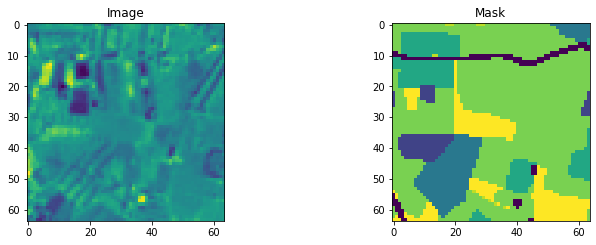

In [ ]:
import random
img_number = random.randint(0, len(image_dataset)-1)
img = image_dataset[img_number]
mask = mask_dataset[img_number]
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.title('Image')
plt.imshow(img[:,:,0])
plt.subplot(222)
plt.title('Mask')
plt.imshow(mask)
plt.show()

In [ ]:
num_classes=11

In [ ]:
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(mask_dataset, num_classes=num_classes)

In [ ]:
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(image_dataset, train_masks_cat, test_size = 0.3)

In [ ]:
X1=preprocess_input(X1)
X_test=preprocess_input(X_test)

In [ ]:
IMG_HEIGHT = X1.shape[1]
IMG_WIDTH  = X1.shape[2]
IMG_CHANNELS = X1.shape[3]

In [ ]:
print(X1.shape)

(547, 64, 64, 3)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
img_data_gen_args = dict(
                    #  width_shift_range=0.3,
                    #  height_shift_range=0.3,
                    #  shear_range=0.5,
#                      zoom_range=0.3,
                     rotation_range=45,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(
                    #  width_shift_range=0.3,
                    #  height_shift_range=0.3,
                    #  shear_range=0.5,
#                      zoom_range=0.3,
                     rotation_range=45,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     ) #Binarize the output again.

In [ ]:
seed=24
image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X1, augment=True, seed=seed)
image_generator = image_data_generator.flow(X1, seed=seed)
valid_img_generator = image_data_generator.flow(X_test, seed=seed)

In [ ]:
mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y1, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y1, seed=seed)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed)

In [ ]:
def my_image_mask_generator(image_generator, mask_generator,num_classes):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
#         img, mask = preprocess_data(image, mask, num_classes)
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator,num_classes)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator,num_classes)

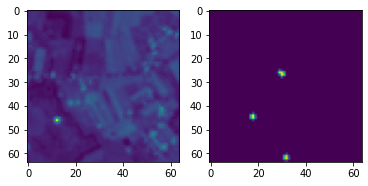

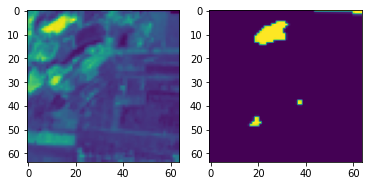

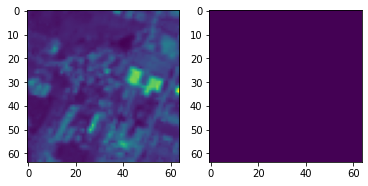

In [ ]:
x = image_generator.next()
y = mask_generator.next()
for i in range(0,3):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0])
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

batch_size = 16
steps_per_epoch = 3*(len(image_dataset))//batch_size

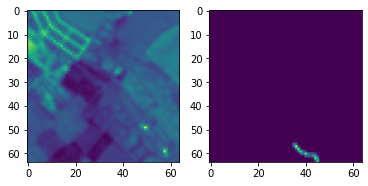

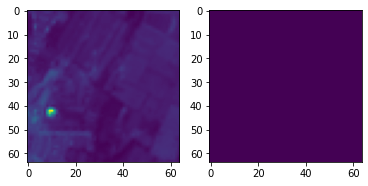

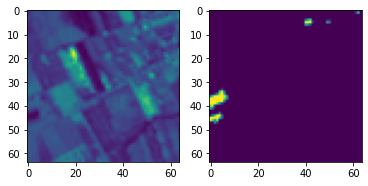

In [ ]:
x = valid_img_generator.next()
y = valid_mask_generator.next()
for i in range(0,3):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0])
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

In [ ]:
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [ ]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=num_classes, activation='softmax')
# model.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])

#Other losses to try: categorical_focal_dice_loss, cce_jaccard_loss, cce_dice_loss, categorical_focal_loss

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())
print(model.input_shape)

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 64, 64, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 block1_conv2 (Conv2D)          (None, 64, 64, 64)   36928       ['block1_conv1[0][0]']           
                                                                                                  
 block1_pool (MaxPooling2D)     (None, 32, 32, 64)   0           ['block1_conv2[0][0]']           
                             

In [ ]:
history=model.fit(my_generator,
                  steps_per_epoch=steps_per_epoch,
          epochs=250,
#           verbose=1,
          validation_data=validation_datagen,
          validation_steps=20
)

Epoch 1/250
146/146 [==============================] - 50s 240ms/step - loss: 1.8216 - categorical_accuracy: 0.3903 - val_loss: 1.8418 - val_categorical_accuracy: 0.3822
Epoch 2/250
146/146 [==============================] - 26s 181ms/step - loss: 1.6679 - categorical_accuracy: 0.4451 - val_loss: 1.8163 - val_categorical_accuracy: 0.3995
Epoch 3/250
146/146 [==============================] - 26s 179ms/step - loss: 1.6277 - categorical_accuracy: 0.4580 - val_loss: 1.7712 - val_categorical_accuracy: 0.4215
Epoch 4/250
146/146 [==============================] - 27s 182ms/step - loss: 1.5982 - categorical_accuracy: 0.4699 - val_loss: 1.7334 - val_categorical_accuracy: 0.4269
Epoch 5/250
146/146 [==============================] - 27s 182ms/step - loss: 1.5775 - categorical_accuracy: 0.4749 - val_loss: 1.7100 - val_categorical_accuracy: 0.4439
Epoch 6/250
146/146 [==============================] - 26s 181ms/step - loss: 1.5515 - categorical_accuracy: 0.4839 - val_loss: 1.7006 - val_categoric

In [ ]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

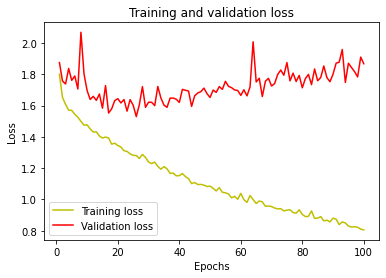

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

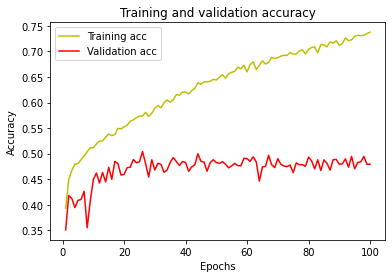

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model.save('landcover_100_epochs_VGG16_backbone_batch16.hdf5')

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("landcover_100_epochs_VGG16_backbone_batch16.hdf5", compile=False)

In [ ]:
test_image_batch, test_mask_batch = validation_datagen.__next__()

#Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

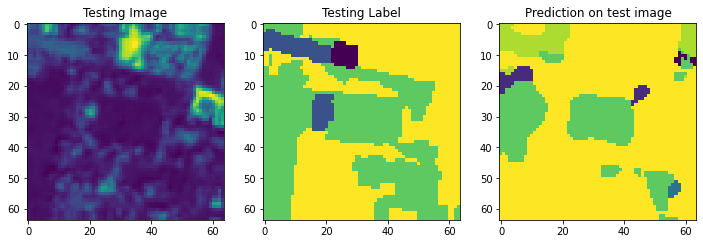

In [ ]:
img_num = random.randint(0, test_image_batch.shape[0]-1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num,:,:,1])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()

(64, 64, 3)
(1, 64, 64, 3)


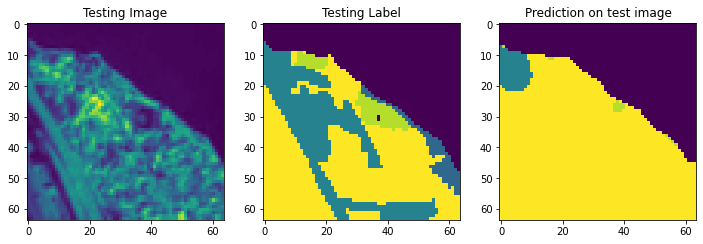

In [ ]:
im1= imread("64images/image_mosaic_101.tif")
mask=imread("64masks/mask_mosaic_101.tif")
print(im1.shape)
im=np.expand_dims(im1,axis=0)
im=preprocess_input(im)
print(im.shape)
p=model.predict(im)
p1 = np.argmax(p, axis=3)
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(im1[:,:,1])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(mask)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(p1[0,:,:])
plt.show()